In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interpn
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

from math import sqrt, atan, log, exp, sin, cos, tan
from thermal_loads_241114 import *

In [2]:
# environment settings: 
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',50)
pd.set_option('display.max_seq_items',None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

np.core.arrayprint.set_printoptions(linewidth= 180)
np.set_printoptions(threshold=np.inf)

# Project name

In [3]:
project = "TVVL"

# Weather data

In [4]:
we = pd.DataFrame.from_dict(we_dict)
we.head()

,CP,Localité,theta_e_base,theta_e_min,theta_e_avg
0,9300,Aalst,-7,0,10
1,9880,Aalter,-7,0,10
2,3200,Aarschot,-7,0,10
3,2630,Aartselaar,-7,0,10
4,1790,Affligem,-7,0,10


In [5]:
we.loc[we['CP'] == 1000]

,CP,Localité,theta_e_base,theta_e_min,theta_e_avg
89,1000,Bruxelles / Brussel,-7,0,10


In [6]:
we[we['Localité'].str.contains("Brux")]

,CP,Localité,theta_e_base,theta_e_min,theta_e_avg
89,1000,Bruxelles / Brussel,-7,0,10


# General data

In [7]:
t_ext = -7
t_min = 0
t_avg = 10

t_in  = 20  # Base internal temperature 

DU    = 0.05      #[W/m2/K]
U_wd  = 1.50 + DU #[W/m2/K]
U_dr  = 1.50 + DU #[W/m2/K]
n_50  = 1

# Reheating additional power (0: imposed oversize factor , 1: EN12831 Annex F Table F1, 2 : EN12831 Annex F Table F3 )
rh_type = 2

# Heat production : set back duration (h), reheating tim (h), heating oversizing factor if it is imposed (>= 1)
time_setback_hp_h   = 36
time_reheat_hp_h    = 6
f_oversize_hp       = 1.3 # Only useful if rh_type = 0

# Ventilation data

In [8]:
##### Zone, internal temperature t_in_star, 
# number of floors, total floor area, internal volume, 
# fan supply air flow (m³/h), fan extracted air flow (m³/h), efficiency of heat recovery,
# ATD outdoor air flow (m³/h), 
# Air flow from indoor adjoining spaces (m³/h), temperature of the indoor adjoining space

vent = \
[('floor_0', 20, 1, 321.84, 321.84*3.01, 45*321.84/10                , 45*321.84/10,                 0.80, 0, 0,20),
 ('floor_1', 20, 1, 321.84, 321.84*3.01, 45*321.84/10                , 45*321.84/10,                 0.80, 0, 0,20),
 ('floor_2', 20, 1, 321.84, 321.84*3.01, 45*321.84/10                , 45*321.84/10,                 0.80, 0, 0,20),
 ('floor_3', 20, 1, 321.84, 321.84*3.01, 45*(218/3.5+(321.84-218)/2) , 45*(218/3.5+(321.84-218)/2) , 0.80, 0, 0,20),
 ('floor_4', 20, 1, 321.84, 321.84*3.01, 45*321.84/10                , 45*321.84/10,                 0.80, 0, 0,20),
 ('floor_5', 20, 1, 246.24, 246.24*3.01, 45*(194/1.5+(246.24-194)/10), 45*(194/1.5+(246.24-194)/10), 0.80, 0, 0,20)]

# System operation

In [9]:
##### Zone, minimum temperature set point, 
# reheating time (h) : after night set back, after more than one day set back (week-end), after more than one week set back, 
# heating oversizing factor if it is imposed (>= 1) , 
# fraction of ventilation during set back time (-)

setback = \
[('floor_0',   15, 2, 6, 12, 1.3, 0),
 ('floor_1',   15, 2, 6, 12, 1.3, 0),
 ('floor_2',   15, 2, 6, 12, 1.3, 0),
 ('floor_3',   15, 2, 6, 12, 1.3, 0),
 ('floor_4',   15, 2, 6, 12, 1.3, 0),
 ('floor_5',   15, 6, 8, 12, 1.3, 0)]

hourly = \
[('floor_0',   (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0) ),
 ('floor_1',   (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0) ),
 ('floor_2',   (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0) ),
 ('floor_3',   (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0) ),
 ('floor_4',   (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0) ),
 ('floor_5',   (0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0) )]

daily = \
[('floor_0',   (1, 1, 1, 1, 1, 0, 0) ),
 ('floor_1',   (1, 1, 1, 1, 1, 0, 0) ),
 ('floor_2',   (1, 1, 1, 1, 1, 0, 0) ),
 ('floor_3',   (1, 1, 1, 1, 1, 0, 0) ),
 ('floor_4',   (1, 1, 1, 1, 1, 0, 0) ),
 ('floor_5',   (1, 1, 1, 1, 1, 0, 0) )]

weekly = \
[('floor_0',   (1, 1, 1, 1, 1, 1, 1, 1, 1) ),
 ('floor_1',   (1, 1, 1, 1, 1, 1, 1, 1, 1) ),
 ('floor_2',   (1, 1, 1, 1, 1, 1, 1, 1, 1) ),
 ('floor_3',   (1, 1, 1, 1, 1, 1, 1, 1, 1) ),
 ('floor_4',   (1, 1, 1, 1, 1, 1, 1, 1, 1) ),
 ('floor_5',   (1, 1, 1, 1, 1, 1, 1, 1, 1) )]

# Wall dimensions and environments

In [10]:
# Zone, azimuth, slope, wall_type, dimension 1, dimension 2, h_in (W/m2-K), h_ext (W/m2-K), t_out (°C)
# radiation heat emission (W/m²)

walls = \
[('floor_0',     0,   0, 'floor_gr',    27.4,   11.6,  8,  23, t_avg, 0),
 ('floor_0',     0,   0, 'floor_gr',    22.4,   1.20,  8,  23, t_avg, 0),
 ('floor_0',   180,  90, 'wall_ext',    12.8,   3.38,  8,   8, t_ext, 0),
 ('floor_0',   -90,  90, 'wall_ext',    21.6,   3.38,  8,   8, t_ext, 0),
 ('floor_0',     0,  90, 'wall_ext',    12.8,   3.38,  8,   8, t_ext, 0),
 ('floor_0',    90,  90, 'wall_ext',    27.4,   3.38,  8,   8, t_ext, 0),
 ('floor_0',     0,  90, 'wall_sep',     5.8,   3.38,  8,   8, t_min, 0),
 ('floor_0',     0, 180, 'ceil_sep_u',  11.6,   27.4,  8,   8, t_in , 0),
 ('floor_0',     0, 180, 'ceil_sep_u',  1.55,   22.4,  8,   8, t_in , 0),
 
 ('floor_1',   180,  90, 'wall_ext',    12.8,   3.405,  8,  8, t_ext, 0),
 ('floor_1',   -90,  90, 'wall_ext',    27.4,   3.405,  8,  8, t_ext, 0),
 ('floor_1',     0,  90, 'wall_ext',    12.8,   3.405,  8,  8, t_ext, 0),
 ('floor_1',    90,  90, 'wall_ext',    27.4,   3.405,  8,  8, t_ext, 0),
 ('floor_1',     0,   0, 'floor_sep_u', 11.6,    27.4,  8,  8, t_in , 0),
 ('floor_1',     0,   0, 'floor_sep_u', 1.55,    22.4,  8,  8, t_in , 0),
 ('floor_1',     0, 180, 'ceil_sep_i',  11.6,    27.4,  8,  8, t_in , 0),
 ('floor_1',     0, 180, 'ceil_sep_i',  1.55,    22.4,  8,  8, t_in , 0),
 
 ('floor_2',   180,  90, 'wall_ext',    12.8,   3.43,  8,   8, t_ext, 0),
 ('floor_2',   -90,  90, 'wall_ext',    27.4,   3.43,  8,   8, t_ext, 0),
 ('floor_2',     0,  90, 'wall_ext',    12.8,   3.43,  8,   8, t_ext, 0),
 ('floor_2',    90,  90, 'wall_ext',    27.4,   3.43,  8,   8, t_ext, 0),
 ('floor_2',     0,   0, 'floor_sep_i', 11.6,   27.4,  8,   8, t_in , 0),
 ('floor_2',     0,   0, 'floor_sep_i', 1.55,   22.4,  8,   8, t_in , 0),
 ('floor_2',     0, 180, 'ceil_sep_i',  11.6,   27.4,  8,   8, t_in , 0),
 ('floor_2',     0, 180, 'ceil_sep_i',  1.55,   22.4,  8,   8, t_in , 0),
 
 ('floor_3',   180,  90, 'wall_ext',    12.8,   3.405,  8,  8, t_ext, 0),
 ('floor_3',   -90,  90, 'wall_ext',    27.4,   3.405,  8,  8, t_ext, 0),
 ('floor_3',     0,  90, 'wall_ext',    12.8,   3.405,  8,  8, t_ext, 0),
 ('floor_3',    90,  90, 'wall_ext',    27.4,   3.405,  8,  8, t_ext, 0),
 ('floor_3',     0,   0, 'floor_sep_i', 11.6,    27.4,  8,  8, t_in , 0),
 ('floor_3',     0,   0, 'floor_sep_i', 1.55,    22.4,  8,  8, t_in , 0),
 ('floor_3',     0, 180, 'ceil_sep_u',  11.6,    27.4,  8,  8, t_in , 0),
 ('floor_3',     0, 180, 'ceil_sep_u',  1.55,    22.4,  8,  8, t_in , 0),
 
 ('floor_4',     0, 180, 'roof_ter',    3.00,   11.6,  8,  23, t_ext, 0),
 ('floor_4',     0, 180, 'roof_ter',    1.60,   11.6,  8,  23, t_ext, 0),
 ('floor_4',     0, 180, 'roof_ter',    27.4,   1.00,  8,  23, t_ext, 0),
 ('floor_4',   180,  90, 'wall_ext',    12.8,   3.38,  8,   8, t_ext, 0),
 ('floor_4',   -90,  90, 'wall_ext',    27.4,   3.38,  8,   8, t_ext, 0),
 ('floor_4',     0,  90, 'wall_ext',    12.8,   3.38,  8,   8, t_ext, 0),
 ('floor_4',    90,  90, 'wall_ext',    27.4,   3.38,  8,   8, t_ext, 0),
 ('floor_4',     0,   0, 'floor_sep_u', 11.6,   27.4,  8,   8, t_in , 0),
 ('floor_4',     0,   0, 'floor_sep_u', 1.55,   22.4,  8,   8, t_in , 0),
 ('floor_4',     0, 180, 'ceil_sep_u', 12.15,   22.4,  8,   8, t_in , 0),
 
 ('floor_5',     0, 180, 'roof',        22.4,  12.15,  8, 23, t_ext, 0),
 ('floor_5',   180,  90, 'wall_ext',   12.15,  3.855,  8,  8, t_ext, 0),
 ('floor_5',   -90,  90, 'wall_ext',    22.4,  3.855,  8,  8, t_ext, 0),
 ('floor_5',     0,  90, 'wall_ext',   12.15,  3.855,  8,  8, t_ext, 0),
 ('floor_5',    90,  90, 'wall_ext',    22.4,  3.855,  8,  8, t_ext, 0),
 ('floor_5',     0,   0, 'floor_sep_u',12.15,  22.40,  8,  8, t_in , 50)] 

In [11]:
# Zone, azimuth, slope, wall_type, number of identical windows, breadth, height
windows = \
[('floor_0',  180, 90, 'wall_ext',  4, 1.20, 1.60),
 ('floor_0',  -90, 90, 'wall_ext',  1, 1.20, 1.60),
 ('floor_0',    0, 90, 'wall_ext',  6, 1.20, 1.60),
 ('floor_0',   90, 90, 'wall_ext', 15, 1.20, 1.60),
 
 ('floor_1',  180, 90, 'wall_ext',  6, 1.20, 1.60),
 ('floor_1',  -90, 90, 'wall_ext',  1, 1.20, 1.60),
 ('floor_1',    0, 90, 'wall_ext',  6, 1.20, 1.60),
 ('floor_1',   90, 90, 'wall_ext', 15, 1.20, 1.60),
 
 ('floor_2',  180, 90, 'wall_ext',  6, 1.20, 1.60),
 ('floor_2',  -90, 90, 'wall_ext',  1, 1.20, 1.60),
 ('floor_2',    0, 90, 'wall_ext',  6, 1.20, 1.60),
 ('floor_2',   90, 90, 'wall_ext', 15, 1.20, 1.60),
 
 ('floor_3',  180, 90, 'wall_ext',  6, 1.20, 1.60),
 ('floor_3',  -90, 90, 'wall_ext',  1, 1.20, 1.60),
 ('floor_3',    0, 90, 'wall_ext',  6, 1.20, 1.60),
 ('floor_3',   90, 90, 'wall_ext', 15, 1.20, 1.60),
 
 ('floor_4',  180, 90, 'wall_ext',  6, 1.20, 1.60),
 ('floor_4',  -90, 90, 'wall_ext',  1, 1.20, 1.60),
 ('floor_4',    0, 90, 'wall_ext',  6, 1.20, 1.60),
 ('floor_4',   90, 90, 'wall_ext', 15, 1.20, 1.60),
 

 ('floor_0',  180, 90, 'wall_ext',   1, 1.20, 2.40),
 ('floor_0',  -90, 90, 'wall_ext', 5.5, 1.80, 0.80),
 ('floor_0',    0, 90, 'wall_ext',   1, 1.20, 2.40),
 
 ('floor_1',  180, 90, 'wall_ext',   1, 1.20, 2.40),
 ('floor_1',  -90, 90, 'wall_ext', 5.5, 1.80, 0.80),
 ('floor_1',    0, 90, 'wall_ext',   1, 1.20, 2.40),
 
 ('floor_2',  180, 90, 'wall_ext',   1, 1.20, 2.40),
 ('floor_2',  -90, 90, 'wall_ext', 5.5, 1.80, 0.80),
 ('floor_2',    0, 90, 'wall_ext',   1, 1.20, 2.40),
 
 ('floor_3',  180, 90, 'wall_ext',   1, 1.20, 2.40),
 ('floor_3',  -90, 90, 'wall_ext', 5.5, 1.80, 0.80),
 ('floor_3',    0, 90, 'wall_ext',   1, 1.20, 2.40),
 
 ('floor_4',  180, 90, 'wall_ext',   1, 1.20, 2.40),
 ('floor_4',  -90, 90, 'wall_ext', 5.5, 1.80, 0.80),
 ('floor_4',    0, 90, 'wall_ext',   1, 1.20, 2.40),

 ('floor_5',  180, 90, 'wall_ext',   1, 11.8, 2.40),
 ('floor_5',  -90, 90, 'wall_ext', 5.5,  1.8, 0.80),
 ('floor_5',    0, 90, 'wall_ext',   1, 11.8, 2.40),
 ('floor_5',   90, 90, 'wall_ext',   1, 22.4, 2.40)]

In [12]:
# Zone, azimuth, slope, wall_type, number of identical external doors, breadth, height
doors = \
[]

# Materials data

In [13]:
materials_list = []

materials_list.append({"material":'concrete_bloc'      ,"lambda":1.36,"rho":2000,"c":1000})
materials_list.append({"material":'insulation'         ,"lambda":0.026,"rho":80, "c":840})
materials_list.append({"material":'reinforced_concrete',"lambda":2.30,"rho":2400,"c":1000})
materials_list.append({"material":'concrete'           ,"lambda":2.10,"rho":2400,"c":1000})
materials_list.append({"material":'brick'              ,"lambda":1.59,"rho":2200,"c":1000})
materials_list.append({"material":'screed'             ,"lambda":1.40,"rho":2000,"c":1000})
materials_list.append({"material":'foamglass'          ,"lambda":0.055,"rho":150,"c":1000})

materials = pd.DataFrame(materials_list)

# Wall types data

In [14]:
# From indoor to outdoor

# Standard insulation

walls_types = \
[('wall_ext', 0, 0.190, 'concrete_bloc'),
 ('wall_ext', 1, 0.100, 'insulation'),
 
 ('wall_sep', 0, 0.190, 'concrete_bloc'),
 
 ('roof'    , 0, 0.300, 'reinforced_concrete'),
 ('roof'    , 1, 0.200, 'insulation'),
 
 ('roof_ter', 0, 0.300, 'reinforced_concrete'),
 ('roof_ter', 1, 0.120, 'insulation'),
 
 ('floor_gr', 0, 0.070, 'screed'),
 ('floor_gr', 1, 0.300, 'concrete'),
 ('floor_gr', 2, 0.080, 'foamglass'),
 
 ('floor_sep_u', 0, 0.300, 'concrete'),
 ('floor_sep_u', 1, 0.070, 'screed'),
 
 ('floor_sep_i', 0, 0.300, 'concrete'),
 ('floor_sep_i', 1, 0.050, 'insulation'),
 ('floor_sep_i', 2, 0.075, 'screed')
]


walls_types = add_inverse_copy('floor_sep_u', 'ceil_sep_u' , walls_types)
walls_types = add_inverse_copy('floor_sep_i', 'ceil_sep_i' , walls_types)

In [15]:
# list of wall types in contact with the ground
GRwalls = ['floor_gr']

# list of wall types with thermal bridges
DUwalls = ['wall_ext', 'roof', 'roof_ter']

# list of wall types separating building entities
BEwalls = []

# List of internal walls totally included in the zone (both faces in contact with the same zone) > define two walls
INTwalls = []

# Heating power

In [16]:
gen = [t_ext, t_in, t_min, t_avg, t_in, DU, U_wd, U_dr, n_50, rh_type, time_setback_hp_h, time_reheat_hp_h, f_oversize_hp]

dfRC, dfRC_hp, dfh, dfd, dfw, \
dfwc, dfwp, dfar, dfat, dfhl, dfzg, dfresz, dfresa, zname_list   = \
            thermal_loads(gen, vent, setback, hourly, daily, weekly, \
                        walls, windows, doors, materials, walls_types,  \
                        GRwalls, DUwalls, BEwalls, INTwalls)

# Heat loss coefficients

,H_T_wl,H_T_wd,H_T_dr,H_V_su,H_V_ATD,H_V_ia,H_V_ie
zone,,,,,,,
floor_0,208.44,98.58,0.0,96.55,0.0,0.0,32.29
floor_1,59.02,104.53,0.0,96.55,0.0,0.0,32.29
floor_2,59.60,104.53,0.0,96.55,0.0,0.0,32.29
floor_3,59.02,104.53,0.0,342.62,0.0,0.0,32.29
floor_4,78.92,104.53,0.0,96.55,0.0,0.0,32.29
floor_5,90.02,183.40,0.0,403.67,0.0,0.0,24.71


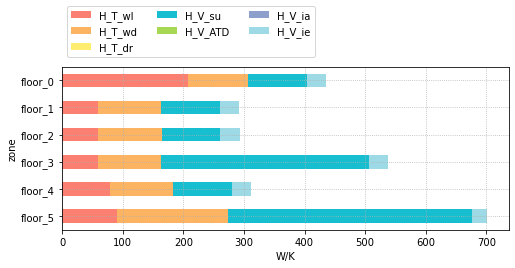

In [17]:
c1 = (0.984313725490196, 0.5019607843137255, 0.4470588235294118)   # orange
c2 = (0.9921568627450981, 0.7058823529411765, 0.3843137254901961)  # orange pastel
c3 = (1.0, 0.9294117647058824, 0.43529411764705883) # yellow
c4 = (0.09019607843137255, 0.7450980392156863, 0.8117647058823529) # blue
c5 = (0.6509803921568628, 0.8470588235294118, 0.32941176470588235) # green-yellow
c6 = (0.5529411764705883, 0.6274509803921569, 0.796078431372549)   # mean blue
c7 = (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)  # lightblue

dfzg.iloc[::-1].plot.barh(figsize=(8,3),stacked=True, color = (c1,c2,c3,c4,c5,c6,c7))
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.4), ncol=3);
plt.xlabel("W/K")
plt.grid(linestyle = 'dotted');

dfzg[['H_T_wl', 'H_T_wd', 'H_T_dr','H_V_su', 'H_V_ATD', 'H_V_ia', 'H_V_ie']].round(2)

# Thermal loads by zone

,Transmission [W],Ventilation [W],Reheating [W],Total [W],Reheat oversizing factor,Radiative fraction
zone,,,,,,
floor_0,8289,3478,6585,18353,1.56,0.00
floor_1,4416,3478,7124,15019,1.90,0.00
floor_2,4431,3478,4848,12759,1.61,0.00
floor_3,4416,10122,3516,18055,1.24,0.00
floor_4,4953,3478,5157,13589,1.61,0.00
floor_5,7382,11566,6248,25197,1.33,0.54
heat_production,33888,35603,13541,83033,1.19,0.16


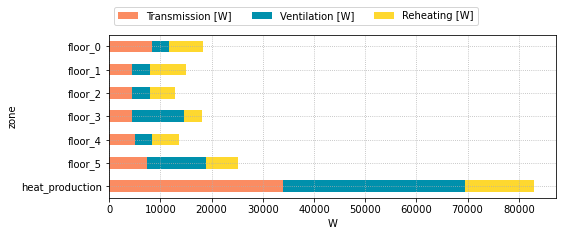

In [18]:
c0 = (102/256, 194/256, 165/256)  # green
c1 = (252/256, 141/256, 98/256)   # orange
c2 = (141/256, 160/256, 203/256)  # blue
c3 = (231/256, 138/256, 195/256)  # pink
c4 = (166/256, 216/256, 84/256)   # light green
c5 = (255/256, 217/256, 47/256)   # yellow
c6 = (229/256, 196/256, 148/256)  # beige
c7 = (179/256, 179/256, 179/256)  # grey
c8 = (250/256, 170/256, 174/256)  # old pink
c9 = (  0/256, 145/256, 173/256)  # dark blue
c10 = (248/256, 234/256, 173/256) # ivory


dfresz[['Transmission [W]','Ventilation [W]','Reheating [W]']].iloc[::-1].plot.barh(figsize=(8,3),stacked=True,color=(c1,c9,c5))
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.2), ncol=3);
plt.xlabel("W")
plt.grid(linestyle = 'dotted');

dfresz

# Thermal loads by zone and by facade

In [19]:
dfresa

,azimuth,Transmission [W],Ventilation [W],Reheating [W],Total [W]
zone,,,,,
floor_0,-90,2107,1007,1906,5021
floor_0,0,1541,596,1129,3268
floor_0,90,3230,1277,2418,6926
floor_0,180,1410,596,1129,3137
floor_1,-90,1056,1185,2428,4670
floor_1,0,828,553,1134,2516
floor_1,90,1703,1185,2428,5317
floor_1,180,828,553,1134,2516
floor_2,-90,1061,1185,1652,3899


# Energy consumptions

In [20]:
%%time

zname_list, day, t_ext_sbs, Tiiv, fr_overcooliz, Qhiv, Qhiz_kWh, Ticv, fr_overcoolcz, Qhcv, Qhcz_kWh, DQh, dfsim_list \
            = simulation(dfRC, dfh, dfd, dfw)


with pd.ExcelWriter(project + ".xlsx") as writer: 
    
    # Wall layers
    dfwc.to_excel(writer, sheet_name='wall_layers') 

    # Wall u_values
    dfwp.to_excel(writer, sheet_name='wall_parameters') 

    # Wall areas by facade
    dfar.to_excel(writer, sheet_name='wall_areas_by_orientation') 

    # Wall total areas 
    dfat.to_excel(writer, sheet_name='wall_areas') 

    # Zone Heat loss Coefficients
    dfhl.to_excel(writer, sheet_name='Heat_loss_coefficients') 

    # Heating powers by zone
    dfresz.to_excel(writer, sheet_name='powers_by_zone') 

    # Results by facade
    dfresa.to_excel(writer, sheet_name='powers_by_zone_and_facade') 

    for i in range(0, len(dfRC)):

        # simulation results 
        dfsim_list[i].to_excel(writer, sheet_name=zname_list[i]) 

Wall time: 1min 44s


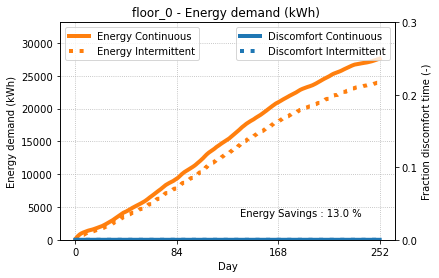

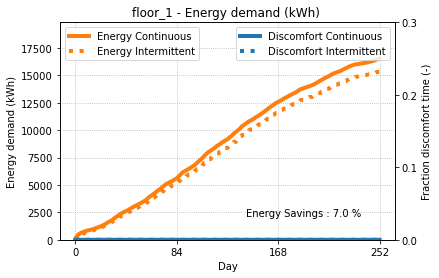

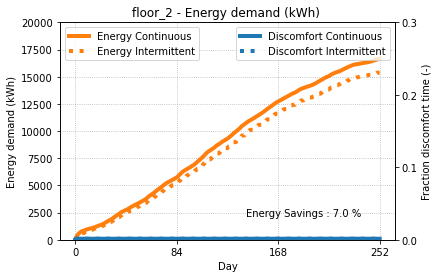

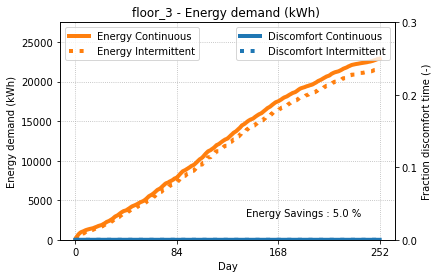

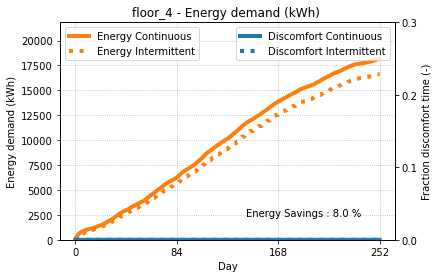

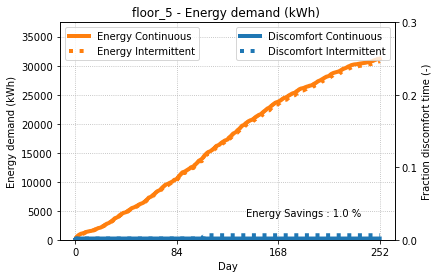

In [21]:
for i in range(0, len(dfRC)):
    
    fig, ax1 = plt.subplots(figsize = (6,4));
    
    Emax = max(Qhcz_kWh[i,-1], Qhiz_kWh[i,-1])
    ax1.plot(day, Qhcz_kWh[i,:],'tab:orange', linewidth=4, label="Energy Continuous")
    ax1.plot(day, Qhiz_kWh[i,:],'tab:orange', linestyle = 'dotted', linewidth=4, label="Energy Intermittent")
    ax1.grid(linestyle = 'dotted')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Energy demand (kWh)')
    ax1.set_ylim([0, 1.2 * Emax])

    plt.title(zname_list[i] + ' - Energy demand (kWh) ')
    plt.xticks(np.arange(0, day[-1] + 1, 14 * 6))

    ax2 = ax1.twinx()
    Fmax = max(fr_overcoolcz[i,-1], fr_overcooliz[i,-1])
    Fmaxgraph = (int(Fmax * 10) + 3) / 10
    ax2.plot(day, fr_overcoolcz[i,:],'tab:blue', linewidth=4, label="Discomfort Continuous")
    ax2.plot(day, fr_overcooliz[i,:],'tab:blue', linestyle = 'dotted', linewidth=4, label="Discomfort Intermittent")
    ax2.set_ylabel('Fraction discomfort time (-)')
    ax2.set_ylim([0,Fmaxgraph])
    ax2.set_yticks(np.arange(0, Fmaxgraph + 0.1, 0.1))

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax2.text(0.9, 0.1, 'Energy Savings : ' + str(DQh[i]) + ' %', \
         horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes);

In [22]:
# Simulation in winter : days 0 to 252
# Graph
day_start = 98
day_stop  = 112

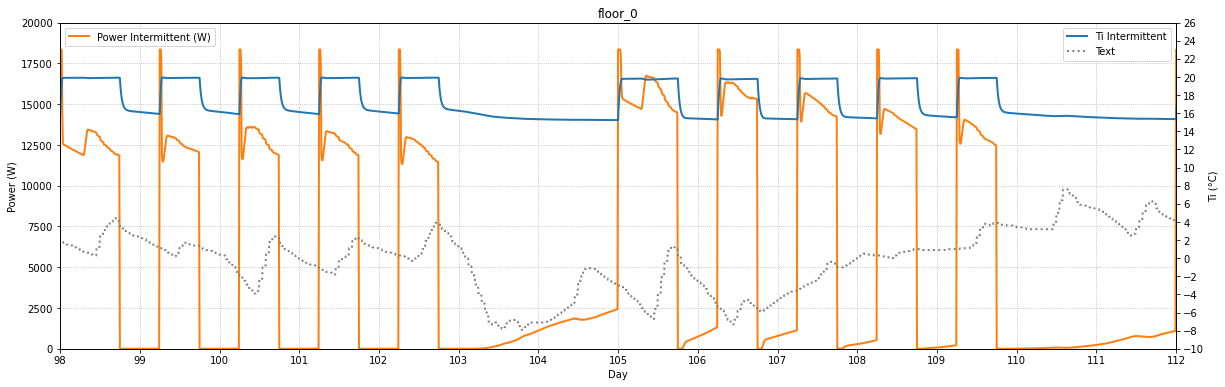

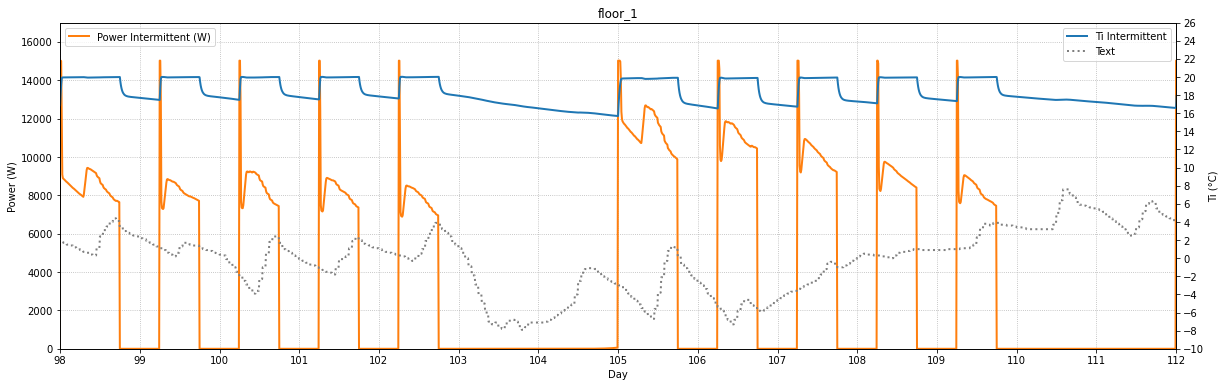

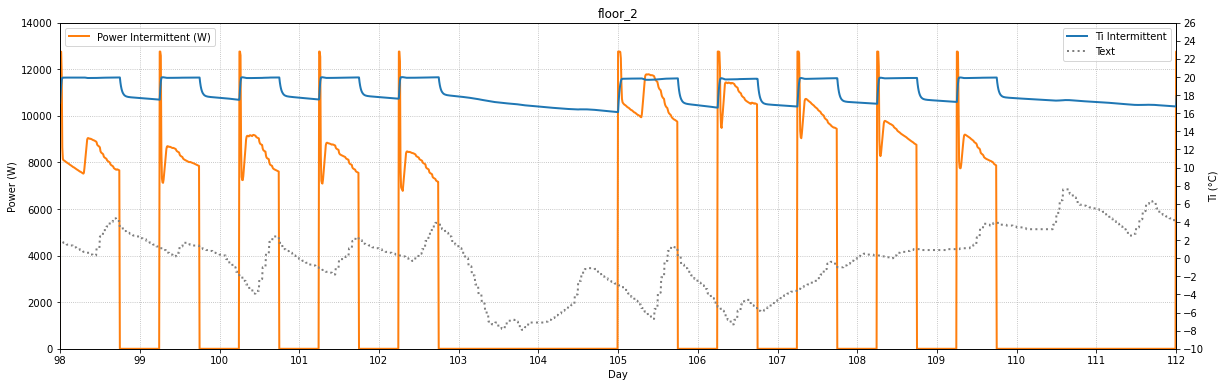

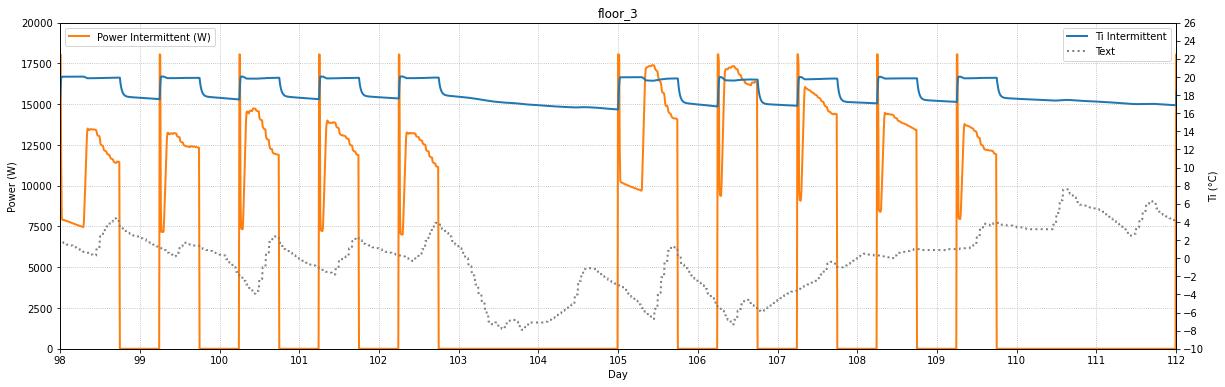

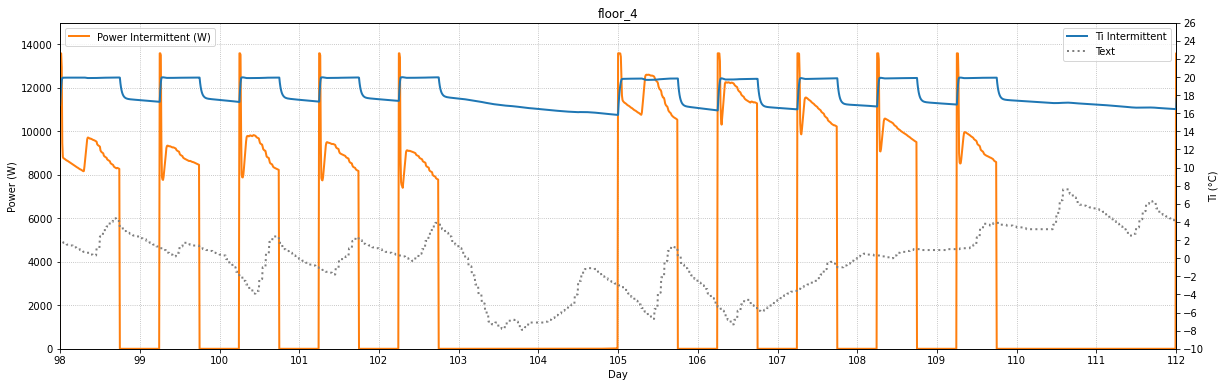

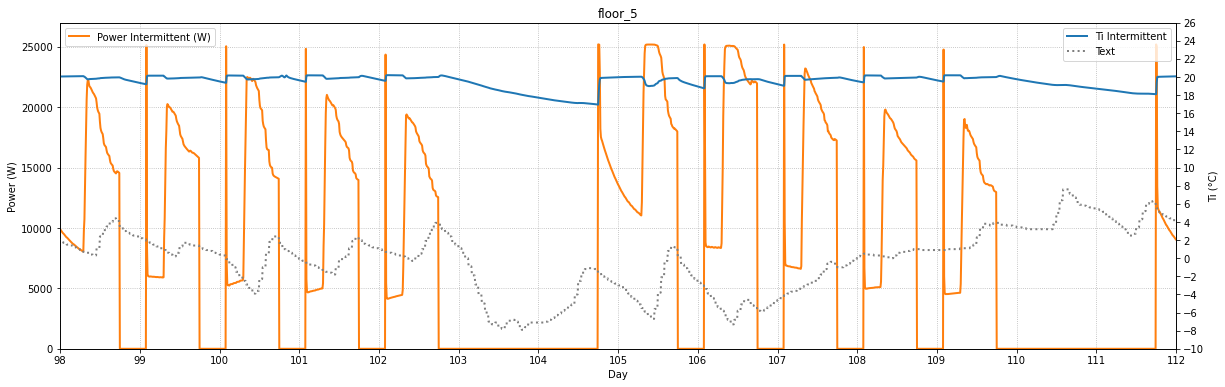

In [23]:
for i in range(0, len(dfRC)):
    
    fig, ax1 = plt.subplots(figsize = (20,6));
    
    Emax = np.max(Qhiv[i,:])
    Qmaxgraph = (int(Emax / 1000) + 2) * 1000
    ax1.plot(day, Qhiv[i,:],'tab:orange',  linewidth=2, label="Power Intermittent (W)")
    # ax1.plot(day, Qhcv[i,:],'tab:orange',  linewidth=2, linestyle = 'dotted', label="Power Continuous   (W)")
    ax1.grid(linestyle = 'dotted')
    ax1.set_xlabel('Day')
    ax1.set_ylabel('Power (W)')
    ax1.set_ylim([0, Qmaxgraph])

    plt.title(zname_list[i])
    plt.xticks(np.arange(0, day[-1] + 1, 1))

    plt.xlim(day_start, day_stop)

    ax2 = ax1.twinx()
    ax2.plot(day, Tiiv[i,:],'tab:blue', linewidth=2, label="Ti Intermittent")
    ax2.plot(day, t_ext_sbs,'tab:grey', linewidth=2, linestyle = 'dotted', label="Text")
    ax2.set_ylabel('Ti (°C)')
    ax2.set_ylim([0, 22])
    ax2.set_yticks(np.arange(-10, 28, 2))

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right');